SpaceX launch anlysis
Analyzing SpaceX launch data from the public API to understand launch success rates by rocket, pad and year

#1 Fetch launch data
Start by calling the '/launches' endpoint of the SpaceX API and store the data in a dataframe.

In [16]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from src.process import get_launch_data, get_rocket_data, get_launchpad_data

In [33]:
from src.fetch import get_launch_data, get_rocket_data, get_launchpad_data
from src.process import transform, summarize_launches

def main():
    # Fetch data
    launches = get_launch_data()
    rockets = get_rocket_data()
    pads = get_launchpad_data()

    # Transform data
    df = transform(launches, rockets, pads)

    # Summarize launches
    summary = summarize_launches(df)

    summary.to_csv("data/summary.csv", index=False)
    print("SpaceX Launch Summary pipeline completed successfully!")
    # Display results
    display(summary)

if __name__ == "__main__":
    main()

ImportError: cannot import name 'transform' from 'src.process' (/Users/mike/Documents/github/spacex-api-analysis/src/process.py)

In [ ]:
def get_launch_data(): #launch_df
    # Fetch data
    url = "https://api.spacexdata.com/v4/launches"
    response = requests.get(url)
    if response.status_code == 200:
        launches = response.json()
    # Extract relevant fields
        return pd.DataFrame([{
            "launch_name": launch["name"],
            "date": launch["date_utc"],
            "success": launch["success"],
            "rocket_id": launch["rocket"],
            "payloads": len(launch["payloads"]),
            "launchpad_id": str(launch["launchpad"])
        } for launch in launches])   
    else:
        print("Error fetching data:", response.status_code)
        return pd.DataFrame()

# df = get_launch_data()
# display(df.head())
# df.to_csv('data/spacex_launches.csv', index=False)

,launch_name,date,success,rocket_id,payloads,launchpad_id
0,FalconSat,2006-03-24T22:30:00.000Z,False,5e9d0d95eda69955f709d1eb,1,5e9e4502f5090995de566f86
1,DemoSat,2007-03-21T01:10:00.000Z,False,5e9d0d95eda69955f709d1eb,1,5e9e4502f5090995de566f86
2,Trailblazer,2008-08-03T03:34:00.000Z,False,5e9d0d95eda69955f709d1eb,2,5e9e4502f5090995de566f86
3,RatSat,2008-09-28T23:15:00.000Z,True,5e9d0d95eda69955f709d1eb,1,5e9e4502f5090995de566f86
4,RazakSat,2009-07-13T03:35:00.000Z,True,5e9d0d95eda69955f709d1eb,1,5e9e4502f5090995de566f86


#2 Add Rocket Names
Fetch rocket data from '/rockets' endpoint and join on rocket_id. adding actual rocket name to dataframe

In [ ]:
def get_rocket_data(): #rocket_df

    all_rockets_url = f"https://api.spacexdata.com/v4/rockets"
    response = requests.get(all_rockets_url)
    if response.status_code == 200:
        rockets = response.json()
        return pd.DataFrame([{
            "rocket_id": rocket["id"]
            ,"rocket_name": rocket["name"]
        } for rocket in rockets])
    else:
        print("Error fetching rocket data:", response.status_code)
        return pd.DataFrame()


#df = df.merge(rocket_df, on="rocket_id", how="left")

,rocket_id,rocket_name
0,5e9d0d95eda69955f709d1eb,Falcon 1
1,5e9d0d95eda69973a809d1ec,Falcon 9
2,5e9d0d95eda69974db09d1ed,Falcon Heavy
3,5e9d0d96eda699382d09d1ee,Starship


#3 Fetch launchpad data
Join on launchpad id, adding a launchpad name and location to the data.

In [ ]:
def get_launchpad_data(): #launchpad_df
    launchpads_url = "https://api.spacexdata.com/v4/launchpads"

    response = requests.get(launchpads_url)
    if response.status_code == 200:
        launchpads = response.json()

        return pd.DataFrame([{
            "launchpad_id": pad["id"]
            ,"launchpad_name": pad["name"]
            ,"launchpad_location": pad["locality"]
        } for pad in launchpads ])
    else:
        print("Error fetching launchpad data:", response.status_code)
        return pd.DataFrame()

#df = df.merge(launchpad_df, on="launchpad_id", how="left").dropna()

,launchpad_id,launchpad_name,launchpad_location
0,5e9e4501f5090910d4566f83,VAFB SLC 3W,Vandenberg Space Force Base
1,5e9e4501f509094ba4566f84,CCSFS SLC 40,Cape Canaveral
2,5e9e4502f5090927f8566f85,STLS,Boca Chica Village
3,5e9e4502f5090995de566f86,Kwajalein Atoll,Omelek Island
4,5e9e4502f509092b78566f87,VAFB SLC 4E,Vandenberg Space Force Base


#4 Launch Success Summary
Convert launch dates to datetime format and extract the launch year. Then, we group the data by rocket name, launchpad, and year to calculate:
- **Total launches**
- **Number of successful launches**
- **Success rate (%)**
The result is a summary table showing launch performance across different rockets, pads, and years.

In [ ]:

df["date"] = pd.to_datetime(df["date"])
df["year"] = df["date"].dt.year

grouped_df = df.groupby(["rocket_name","launchpad_name","year"])

summary = grouped_df["success"].agg(
    total_launches="count"
    ,successful_launches = lambda x: x.sum()
    ,success_rate=lambda x:(x.sum() / x.count()) * 100
).reset_index()

summary = summary.sort_values(by="success_rate", ascending=False)

display(summary)

,rocket_name,launchpad_name,year,total_launches,successful_launches,success_rate
3,Falcon 1,Kwajalein Atoll,2009,1,True,100.000000
6,Falcon 9,CCSFS SLC 40,2013,2,2,100.000000
5,Falcon 9,CCSFS SLC 40,2012,2,2,100.000000
4,Falcon 9,CCSFS SLC 40,2010,2,2,100.000000
7,Falcon 9,CCSFS SLC 40,2014,6,6,100.000000
13,Falcon 9,CCSFS SLC 40,2020,14,14,100.000000
10,Falcon 9,CCSFS SLC 40,2017,1,True,100.000000
11,Falcon 9,CCSFS SLC 40,2018,12,12,100.000000
14,Falcon 9,CCSFS SLC 40,2021,16,16,100.000000
15,Falcon 9,CCSFS SLC 40,2022,21,21,100.000000


#5 Export Summary Data
Export summerized launch performance data to a CSV file under 'data' folder

In [40]:
summary.to_csv('data/spacex_summary.csv', index=False)

#6 Launches per Rocket
Plot a bar chart showing the number of launches per rocket. Giving a quick view of which rockets are most active.

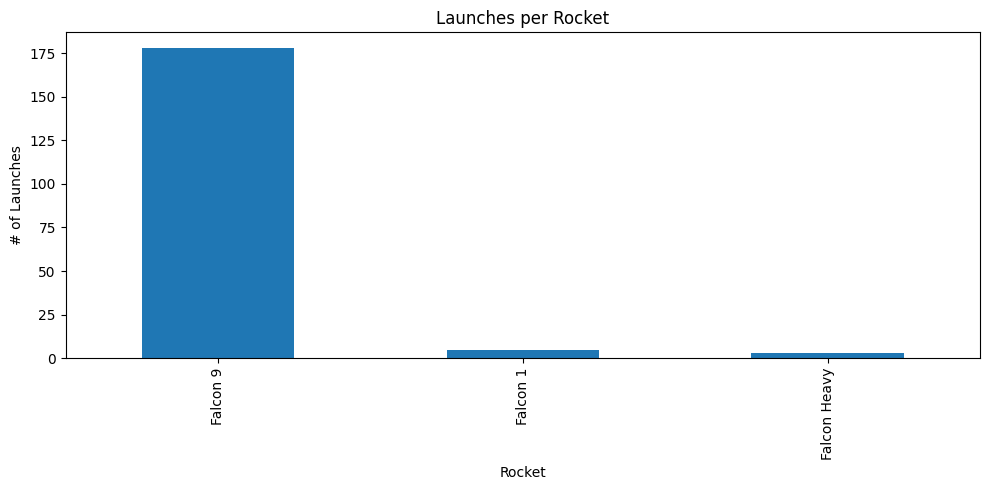

In [41]:

rocket_counts = df['rocket_name'].value_counts()
rocket_counts.plot(kind='bar', figsize=(10,5), title='Launches per Rocket')
plt.xlabel('Rocket')
plt.ylabel('# of Launches')
plt.tight_layout()
plt.show()

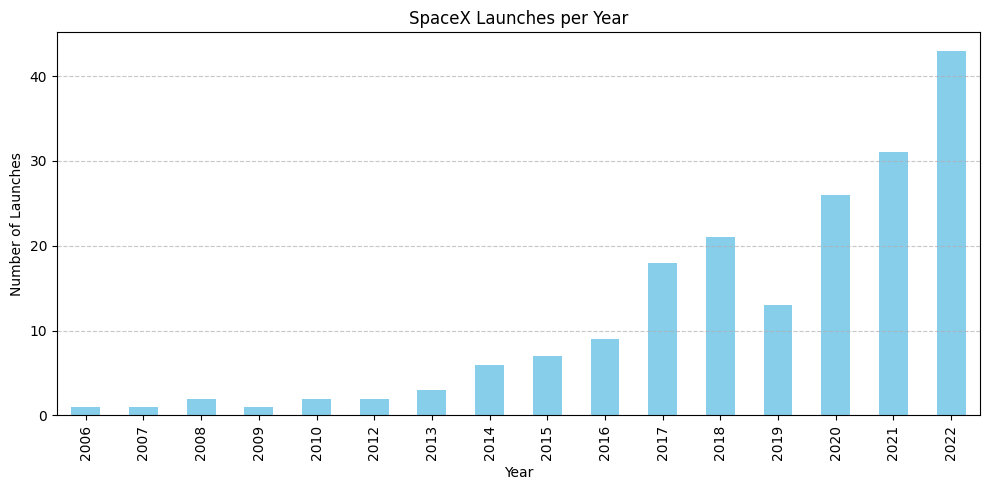

In [42]:
# Group by year and count launches
launches_per_year = df['year'].value_counts().sort_index()

plt.figure(figsize=(10,5))
launches_per_year.plot(kind='bar', color='skyblue')
plt.title('SpaceX Launches per Year')
plt.xlabel('Year')
plt.ylabel('Number of Launches')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

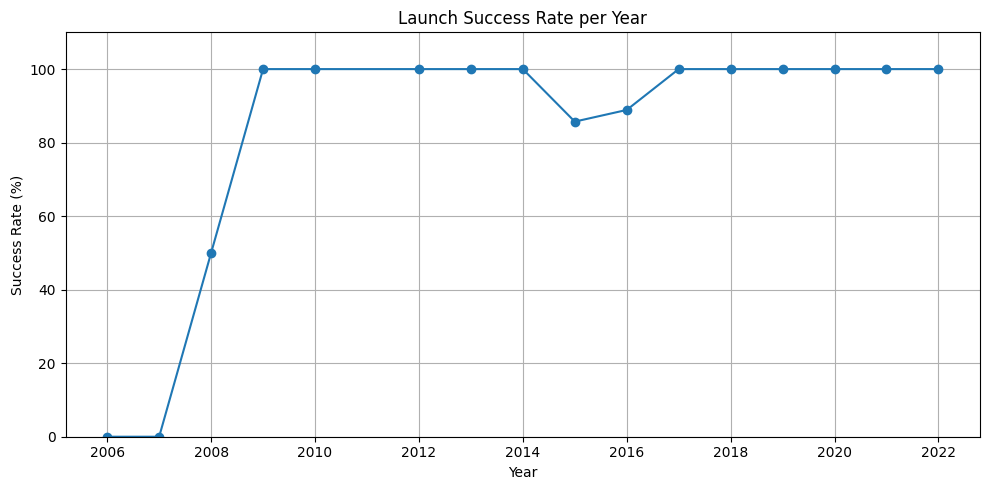

In [43]:
# Calculate success rate per year
success_by_year = df.groupby('year')['success'].agg(
    total='count',
    successful='sum'
)
success_by_year['success_rate'] = (success_by_year['successful'] / success_by_year['total']) * 100

# Plot
plt.figure(figsize=(10,5))
success_by_year['success_rate'].plot(marker='o', linestyle='-')
plt.title('Launch Success Rate per Year')
plt.xlabel('Year')
plt.ylabel('Success Rate (%)')
plt.ylim(0, 110)
plt.grid(True)
plt.tight_layout()
plt.show()